In [74]:
import calendar
import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import wrds
from sklearn.datasets import load_iris
import statsmodels.api as sm
from pystout import pystout

## Obtain merged dataset

### 1.5 Automatic authentication with .pgass file

In [ ]:
load_dotenv() # Use your env file to get access to WRDS
WRDS_USERNAME = os.getenv("wrdsname")

db = wrds.Connection(wrds_username = WRDS_USERNAME)

Loading library list...
Done


### 1.7 Compustat Data

##### SQL query to retrieve annual Compustat data from WRDS, selecting specific financial variables for a given date range (datestart to dateend).

In [76]:
var_list = {
    "comp_annual": "fyear, fyr, ceq, txditc, pstkl, pstkrv, pstk",
    "crsp_monthly": "ret, retx, shrout, prc, cfacpr"
}

datestart = '1960-01-01' # 1962-07-01 is the desired start date, to be accounted for later in the code
dateend = '2023-12-31' # Desired end date

compa_query = f"""
    SELECT gvkey, datadate AS date, {var_list["comp_annual"]}
    FROM comp.funda
    WHERE indfmt='INDL' AND datafmt='STD' AND popsrc='D' AND consol='C'
    AND datadate BETWEEN '{datestart}' AND '{dateend}'
"""
df_comp_a = db.raw_sql(compa_query)

### 1.8 CRSP Data

##### SQL query to retrieve monthly stock data from CRSP (crsp.mf), merging it with company details from crsp.msenames.

In [77]:
crspm_query = f"""
    SELECT DISTINCT
        a.permno, a.permco, a.date, {var_list["crsp_monthly"]},
        b.shrcd, b.exchcd, b.siccd,
        c.dlret, c.dlstcd
    FROM crsp.msf AS a
    INNER JOIN crsp.msenames AS b
        ON a.permno = b.permno
        AND b.namedt <= a.date
        AND a.date <= b.nameendt
        AND b.exchcd BETWEEN 1 AND 3
    LEFT JOIN crsp.msedelist AS c
        ON a.permno = c.permno
        AND a.date = c.dlstdt
    WHERE a.date BETWEEN '{datestart}' AND '{dateend}'
        AND a.prc IS NOT NULL
    ORDER BY a.permno, a.permco, a.date
"""

df_crsp_m = db.raw_sql(crspm_query)

### 1.9 CRSP-Compustat linktable

##### SQL query to merge Compustat with the linktable at the early stage to obtain valid firm-security pairs.

In [78]:
compa_query = f"""
    WITH ccm AS (
        SELECT gvkey, lpermno AS permno, lpermco AS permco, linkdt, linkenddt, linktype, linkprim
        FROM crsp.ccmxpf_linktable
        WHERE linktype IN ('LU', 'LC')
        AND linkprim IN ('P', 'C')
    ),
    annual AS (
        SELECT gvkey, datadate AS date, {var_list["comp_annual"]}
        FROM comp.funda
        WHERE indfmt = 'INDL' AND datafmt = 'STD' AND consol = 'C' AND popsrc = 'D'
        AND datadate BETWEEN '{datestart}' AND '{dateend}'
    )
    SELECT DISTINCT
        ccm.permno, ccm.permco, annual.date, {var_list["comp_annual"]}
    FROM ccm
    INNER JOIN annual
        ON ccm.gvkey = annual.gvkey
        AND annual.date >= ccm.linkdt
        AND (ccm.linkenddt >= annual.date OR ccm.linkenddt IS NULL)
    ORDER BY ccm.permno, ccm.permco, annual.date;
"""

df_comp_a = db.raw_sql(compa_query)

##### Close connection

In [79]:
db.close()

### 1.11: Remove the duplicate column gvkey-datadate when using Compustat data

##### Group the data by 'permno' and 'date' (datadate) and retain the recent record within each group

In [80]:
# Ensure 'permno' and 'date' are in the correct format
df_comp_a['date'] = pd.to_datetime(df_comp_a['date'])
df_comp_a['permno'] = df_comp_a['permno'].astype(int)
                                    
# There is no duplicates in annual Compustat data
duplicates = df_comp_a[df_comp_a.duplicated(subset=['permno', 'date'], keep=False)]
print(duplicates)

Empty DataFrame
Columns: [permno, permco, date, fyear, fyr, ceq, txditc, pstkl, pstkrv, pstk]
Index: []


### 1.12 Adjust the Compustat data 'date'

##### Adjust 'date' to account for reporting lag

In [81]:
def apd_months (sourcedate, months):
    """
    Adds a specified number of months to a given date.
    
    Args:
    - sourcedate (datetime.date): The original date.
    - months (int): Number of months to add.
    """
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12 # year will be the same unless shifting by more than 11 months
    month = month % 12 + 1
    day = calendar.monthrange(year, month)[1]
    
    return datetime.date(year, month, day)

df_comp_a['date'] = df_comp_a['date'].apply(lambda x: apd_months(x, 6))

### 1.13 Merge Compustat and CRSP

##### Expand Compustat data.

In [82]:
def expand_to_monthly (df, freq='Y'):
    """
    Expands annual or quarterly data into monthly data.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame containing 'date'.
    - freq (str): 'Y' for annual data , 'Q' for quarterly data.
    
    Returns:
    - pd.DataFrame: Expanded dataset with monthly frequency.
    """
    # Define mapping for expansion
    expand_map = {'Y': 12, 'Q': 3}
    if freq not in expand_map:
        raise ValueError ("freq must be 'Y' (annual) or 'Q' (quarterly).")
    
    expand_count = expand_map[freq]
    
    # Ensure 'date' is datetime
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Expand data by repeating rows
    df_expanded = df.loc[df.index.repeat(expand_count)].reset_index(drop=True)
    
    # Create month offset (0, 1, 2, ...)
    df_expanded['month_offset'] = df_expanded.groupby(['permno', 'date']).cumcount()
    
    # Adjust date
    df_expanded['date'] = df_expanded['date'] + df_expanded['month_offset'].apply(lambda x: pd.DateOffset(months=int(x)))
    df_expanded['date'] = df_expanded['date'] + pd.offsets.MonthEnd(0)
    df_expanded['date'] = pd.to_datetime(df_expanded['date'])
    
    df_expanded.drop(columns=['month_offset'], inplace=True)
                     
    return df_expanded

df_comp_a_monthly = expand_to_monthly(df_comp_a, freq='Y')

C:\Users\65608\AppData\Local\Temp\ipykernel_12232\3256274688.py:30: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_expanded['date'] = df_expanded['date'] + df_expanded['month_offset'].apply(lambda x: pd.DateOffset(months=int(x)))


##### Merge expanded Compustat data with CRSP using permno and date as the merging key. This ensures that financial and market data are correctly aligned for empirical analysis.

In [136]:
def merge_comp_and_crsp (df_comp_monthly , df_crsp_monthly ):
    """
    Merges monthly Compustat data with monthly CRSP data.
    
    Parameters:
    - df_comp_monthly (pd.DataFrame): Monthly Compustat dataset.
    - df_crsp_monthly (pd.DataFrame): Monthly CRSP dataset.
    
    Returns:
    - pd.DataFrame: Merged dataset with monthly frequency.
    """
    # Remove permco from CRSP to prevent duplicates during merging with Compustat
    df_crsp_monthly = df_crsp_monthly.drop(columns = ['permco'])
    df_crsp_monthly['date'] = pd.to_datetime(df_crsp_monthly['date']) + pd.offsets.MonthEnd(0)
    df_comp_monthly['date'] = pd.to_datetime(df_comp_monthly['date']) + pd.offsets.MonthEnd(0)
    
    # Define merge keys
    merge_keys = ['date', 'permno']
    
    # Perform an inner join to keep only matching records
    df_merged = pd.merge(df_comp_monthly, df_crsp_monthly, on=merge_keys, how='inner')
    
    # Drop duplicates
    df_merged = df_merged.drop_duplicates(subset=['date', 'permno'])
                                                      
    return df_merged

df_merged = merge_comp_and_crsp(df_comp_a_monthly, df_crsp_m)
df_merged = df_merged.sort_values(['permno', 'date'], ascending = [True, True])

## Data cleaning

##### Save the merged data before data cleaning into a CSV file

In [84]:
df_merged.to_csv('Data/merged_data.csv', index=False)

##### Shape of dataset before cleaning

In [85]:
df_merged = pd.read_csv('Data/merged_data.csv')
print('Shape of merged dataset:', df_merged.shape)

Shape of merged dataset: (3538110, 20)


##### Modify dataset to only include ordinary shares

In [86]:
df_merged = df_merged[df_merged["shrcd"].isin([10, 11])]
print("Shares included:", df_merged['shrcd'].unique())
print('Shape after only including ordinary shares:', df_merged.shape)

Shares included: [10 11]
Shape after only including ordinary shares: (2881085, 20)


### Two adjustments for survival bias

#### First adjustment: Adjust the returns for delisted stocks

In [87]:
df_merged = df_merged.dropna(subset=['ret'])
df_merged['dlret'] = df_merged['dlret'].fillna(0)
df_merged['ret_adj'] = ((1 + df_merged['ret']) * (1 + df_merged['dlret'])) - 1
print('Shape after delisting adjustment:', df_merged.shape)

Shape after delisting adjustment: (2880063, 21)


#### Second adjustment: Include firms only when they have appeared on Compustat for two years

In [88]:
first_dates = df_merged.groupby('permco')['date'].min().reset_index()
first_dates['date'] = pd.to_datetime(first_dates['date'])
first_dates['entry_date'] = first_dates['date'] + pd.offsets.MonthEnd(24)
df_merged = df_merged.merge(first_dates[['permco', 'entry_date']], on='permco', how='left')
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged = df_merged[df_merged['date'] >= df_merged['entry_date']].drop(columns=['entry_date'])
print('Shape after dropping first two years on Compustat:', df_merged.shape)

Shape after dropping first two years on Compustat: (2402622, 21)


### Computing Book and Market equity

#### Book equity

In [89]:
df_merged['pstk_val'] = (
    df_merged['pstkl']
    .combine_first(df_merged['pstkrv'])
    .combine_first(df_merged['pstk'])
    .fillna(0)
)

df_merged['be'] = np.where(
    df_merged['fyear'] < 1993,
    df_merged['ceq'].fillna(0) + df_merged['txditc'].fillna(0) - df_merged['pstk_val'],
    df_merged['ceq'].fillna(0) - df_merged['pstk_val']
)

df_merged = df_merged.dropna(subset=['ceq'])
print('Shape after computing book equity:', df_merged.shape)

Shape after computing book equity: (2351446, 23)


#### Market equity

In [90]:
df_merged['me'] = abs(df_merged['prc']) * (df_merged['shrout'] / 1e3) # shrout is in thousands
df_merged['me_permco'] = df_merged.groupby(['permco', 'date'])['me'].transform('sum')
df_merged = df_merged.dropna(subset=['me_permco'])
print('Shape after computing market equity and aggregating on company (permco) level:', df_merged.shape)

Shape after computing market equity and aggregating on company (permco) level: (2351446, 25)


#### Time-series of the overall value-weighted market return

In [91]:
columns_to_drop = ['total_me', 'weight', 'weighted_ret', 'vw_ret']
df_merged = df_merged.drop(columns=[col for col in columns_to_drop if col in df_merged.columns], errors='ignore')

df_merged['total_me'] = df_merged.groupby('date')['me_permco'].transform('sum')
df_merged['weight'] = df_merged['me_permco'] / df_merged['total_me']
df_merged['weighted_ret'] = df_merged['weight'] * df_merged['ret_adj']
vw_market_ret = df_merged.groupby('date')['weighted_ret'].sum().reset_index()
vw_market_ret.rename(columns={'weighted_ret': 'vw_ret'}, inplace=True)
df_merged = df_merged.merge(vw_market_ret, on='date', how='left')
print('Shape after computing overall-value weighted market return:', df_merged.shape)

# Save vw_market_ret as an Excel file
vw_market_ret.to_excel('Data/vw_market_ret.xlsx', index=False)

Shape after computing overall-value weighted market return: (2351446, 29)


## Build the portfolios

##### Save the cleaned merged data before building the portfolios into a CSV file

In [92]:
# '1962-07-01' is the first date in the dataset
df_merged = df_merged[df_merged['date'] >= '1962-07-01']
print('Shape after dropping data before 1962-07-01:', df_merged.shape)
df_merged.to_csv('Data/cleaned_data.csv', index=False)

Shape after dropping data before 1962-07-01: (2351446, 29)


##### Shape of dataset before building the portfolios

In [93]:
df_merged = pd.read_csv('Data/cleaned_data.csv')
print('Shape of cleaned merged dataset:', df_merged.shape)

Shape of cleaned merged dataset: (2351446, 29)


##### Drop companies with non-positive equity

In [94]:
df_merged = df_merged[df_merged['be'] > 0]
print('Shape after dropping companies with non-positive equity:', df_merged.shape)

Shape after dropping companies with non-positive equity: (2262574, 29)


### Classify stocks into portfolios

##### Calculate B/M values

In [95]:
df_merged['date'] = pd.to_datetime(df_merged['date']) # Ensure 'date' is in datetime format

# Extract June observations for classification
df_merged['month'] = df_merged['date'].dt.month
df_merged['year'] = df_merged['date'].dt.year
df_june = df_merged[df_merged['month'] == 6].copy()

# Calculate B/M using current year's June book equity and previous year's December market equity
df_june['dec_date'] = pd.to_datetime((df_june['year'] - 1).astype(str) + '-12-31')
df_dec_me = df_merged[df_merged['date'].dt.month == 12][['permco', 'date', 'me_permco']].rename(columns={'date': 'dec_date'})
df_june = df_june.merge(df_dec_me, on=['permco', 'dec_date'], how='left', suffixes=('', '_dec'))
df_june['be_me'] = df_june['be'] / df_june['me_permco_dec']

df_june = df_june.dropna(subset=['be_me'])
df_june = df_june[df_june['be_me'] > 0]
print('Shape of June data after B/M calculation:', df_june.shape)

Shape of June data after B/M calculation: (177797, 34)


##### Compute NYSE breakpoints for size and book-to-market

In [96]:
def compute_nyse_breakpoints(df, year):
    nyse_stocks = df[(df['exchcd'] == 1) & (df['year'] == year)] # exchcd = 1 for NYSE stocks
    
    size_breakpoint = nyse_stocks['me_permco'].median()
    be_me_sorted = nyse_stocks['be_me'].sort_values()
    low_breakpoint = be_me_sorted.quantile(0.3)
    high_breakpoint = be_me_sorted.quantile(0.7)
    
    return size_breakpoint, low_breakpoint, high_breakpoint

# Compute breakpoints for each year
years = df_june['year'].unique()
breakpoints = {}
for year in years:
    size_bp, low_bp, high_bp = compute_nyse_breakpoints(df_june, year)
    breakpoints[year] = {'size': size_bp, 'be_me_low': low_bp, 'be_me_high': high_bp}

# Apply breakpoints to June data
df_june['size_bp'] = df_june['year'].map(lambda x: breakpoints[x]['size'])
df_june['be_me_low_bp'] = df_june['year'].map(lambda x: breakpoints[x]['be_me_low'])
df_june['be_me_high_bp'] = df_june['year'].map(lambda x: breakpoints[x]['be_me_high'])

print('Shape after NYSE breakpoints calculation:', df_june.shape)

Shape after NYSE breakpoints calculation: (177797, 37)


##### Assign classification (size and BM labels) in current year's June

In [97]:
df_june['size_group'] = np.where(df_june['me_permco'] <= df_june['size_bp'], 'Small', 'Big')

df_june['beme_group'] = np.select(
    [df_june['be_me'] <= df_june['be_me_low_bp'],
     df_june['be_me'] > df_june['be_me_high_bp']],
    ['Low', 'High'],
    default='Medium'
)

df_june['portfolio'] = df_june['beme_group'] + '-' + df_june['size_group'] # Combine labels

print('Unique portfolios:', df_june['portfolio'].unique())
print('Shape after classification:', df_june.shape)

Unique portfolios: ['High-Small' 'Medium-Small' 'Medium-Big' 'High-Big' 'Low-Small' 'Low-Big']
Shape after classification: (177797, 40)


##### Apply classifications to the following 12 months (current year's July to next year's June)

In [98]:
# Create a mapping of classifications to apply from current year's July to next year's June
df_june['start_date'] = pd.to_datetime(df_june['year'].astype(str) + '-07-01')
df_june['end_date'] = pd.to_datetime((df_june['year'] + 1).astype(str) + '-06-30')

classification = df_june[['permco', 'start_date', 'end_date', 'portfolio', 'size_group', 'beme_group']].copy()

# Ensure dates are in datetime format and sort both DataFrames
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_portfolios = df_merged.copy()
df_portfolios = df_portfolios.sort_values('date')
classification = classification.sort_values('start_date')

df_portfolios = pd.merge_asof(
    df_portfolios,
    classification,
    left_on='date',
    right_on='start_date',
    by='permco',
    direction='backward' # Look for the most recent classification before or at the date
)

df_portfolios = df_portfolios[df_portfolios['date'] <= df_portfolios['end_date']]

# Drop unnecessary columns and fill missing classifications
df_portfolios = df_portfolios.drop(columns=['start_date', 'end_date'])
df_portfolios['portfolio'] = df_portfolios['portfolio'].fillna('Unclassified')
df_portfolios['size_group'] = df_portfolios['size_group'].fillna('Unclassified')
df_portfolios['beme_group'] = df_portfolios['beme_group'].fillna('Unclassified')

print('Shape of dataset with portfolio classifications:', df_portfolios.shape)

portfolio_counts = df_portfolios['portfolio'].value_counts()
portfolio_shares = df_portfolios['portfolio'].value_counts(normalize=True).round(4)

portfolio_distribution = pd.DataFrame({
    'Total Observations': portfolio_counts,
    'Share': portfolio_shares
})

portfolio_distribution

Shape of dataset with portfolio classifications: (2023853, 34)


,Total Observations,Share
portfolio,,
High-Small,640573,0.3165
Medium-Small,506098,0.2501
Low-Small,386613,0.1910
Low-Big,223432,0.1104
Medium-Big,186757,0.0923
High-Big,80380,0.0397


##### Plot share of stocks in each group over time

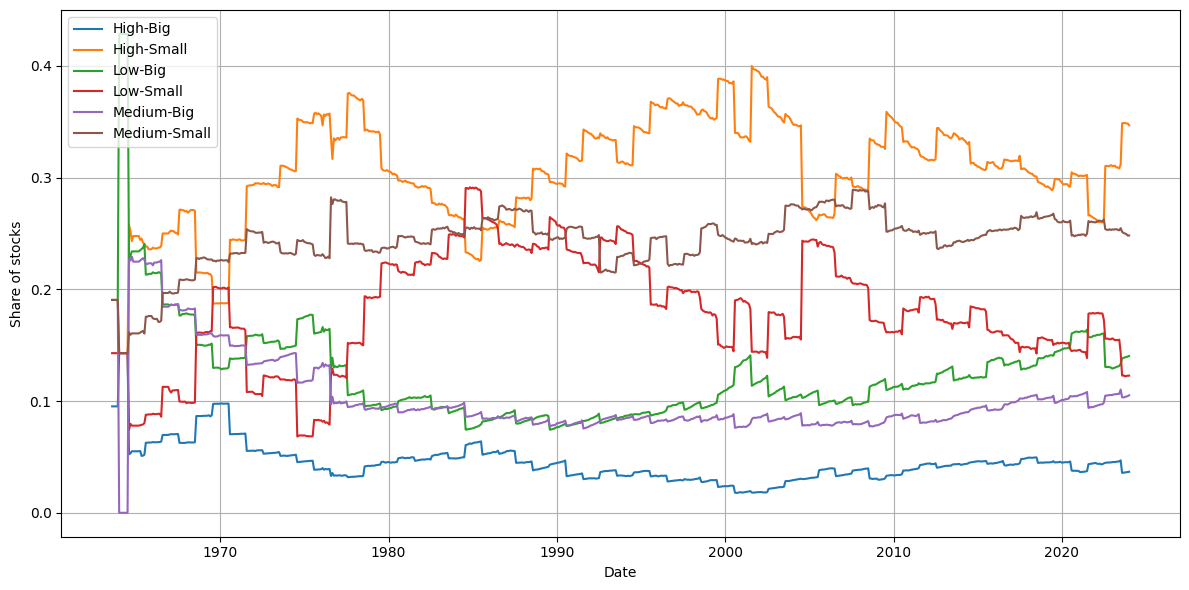

In [99]:
# Calculate share of stocks in each portfolio over time
portfolio_counts = df_portfolios.groupby(['date', 'portfolio']).size().unstack(fill_value=0)
total_stocks = portfolio_counts.sum(axis=1)
portfolio_shares = portfolio_counts.div(total_stocks, axis=0)

# Plot
plt.figure(figsize=(12, 6))
for portfolio in portfolio_shares.columns:
    if portfolio != 'Unclassified':
        plt.plot(portfolio_shares.index, portfolio_shares[portfolio], label=portfolio)
plt.xlabel('Date')
plt.ylabel('Share of stocks')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('Plots/portfolio_shares.pdf')
plt.show()

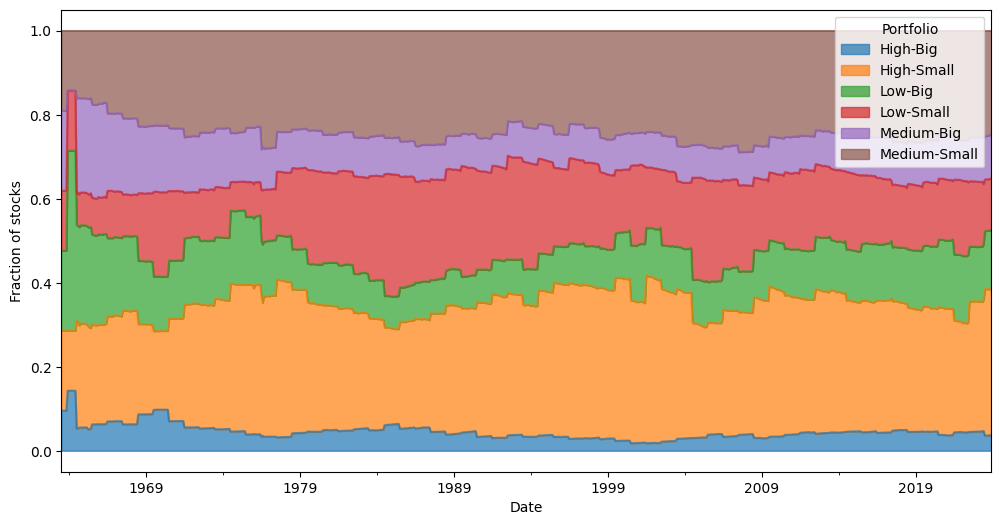

In [100]:
# Plot different kind of figure
df_plot = portfolio_counts.copy()

df_plot.div(df_plot.sum(axis=1), axis=0).plot.area(figsize=(12, 6), alpha=0.7)
plt.ylabel("Fraction of stocks")
plt.xlabel("Date")
plt.legend(title="Portfolio", loc='upper right')
plt.savefig('Plots/portfolio_shares_v2.pdf', format='pdf')
plt.show()

##### Compute the value-weighted return for each portfolio.

Shape of value-weighted returns dataset: (4349, 3)
Shape of pivoted dataset: (726, 6)


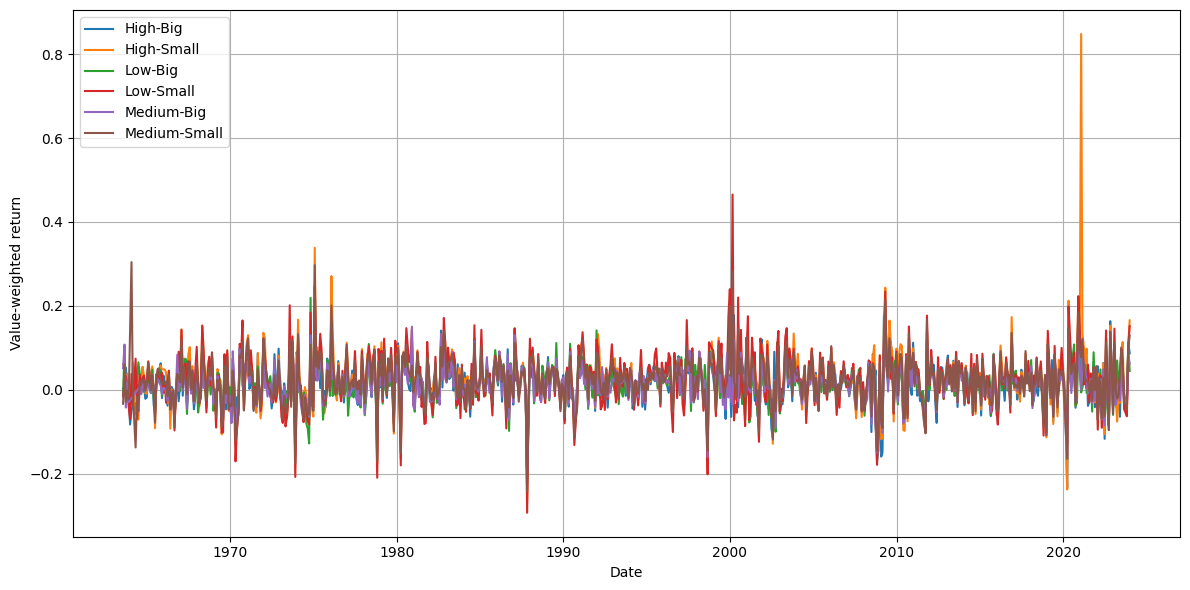

In [101]:
def compute_vw_returns(df):
    """
    Computes value-weighted returns for each portfolio based on market equity.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with portfolio classifications and returns
    
    Returns:
    - pd.DataFrame: DataFrame with value-weighted returns for each portfolio by date
    """
    # Ensure necessary columns are present
    required_cols = ['date', 'portfolio', 'me_permco', 'ret_adj']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("Missing required columns for value-weighted return calculation")
    
    # Calculate weights within each portfolio for each date
    df['portfolio_me'] = df.groupby(['date', 'portfolio'])['me_permco'].transform('sum')
    df['portfolio_weight'] = df['me_permco'] / df['portfolio_me']
    
    # Compute weighted returns
    df['portfolio_weighted_ret'] = df['portfolio_weight'] * df['ret_adj']
    
    # Aggregate to portfolio level
    vw_returns = df.groupby(['date', 'portfolio'])['portfolio_weighted_ret'].sum().reset_index()
    vw_returns.rename(columns={'portfolio_weighted_ret': 'vw_ret'}, inplace=True)
    
    return vw_returns

# Compute value-weighted returns
df_vw_returns = compute_vw_returns(df_portfolios)
print('Shape of value-weighted returns dataset:', df_vw_returns.shape)

# Pivot the data to have the date and then portfolios as the columns
df_vw_returns_pivot = df_vw_returns.pivot(index='date', columns='portfolio', values='vw_ret')
print('Shape of pivoted dataset:', df_vw_returns_pivot.shape)

# Plot monthly value-weighted returns for all 6 portfolios in df_vw_returns
plt.figure(figsize=(12, 6))

for portfolio in df_vw_returns['portfolio'].unique():
    if portfolio != 'Unclassified':
        portfolio_data = df_vw_returns[df_vw_returns['portfolio'] == portfolio]
        plt.plot(portfolio_data['date'], portfolio_data['vw_ret'], label=portfolio)
    
plt.xlabel('Date')
plt.ylabel('Value-weighted return')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('Plots/vw_returns_six_portfolios.pdf')
plt.show()

# Save pivoted dataset as excel file
df_vw_returns_pivot.to_excel('Data/vw_returns.xlsx')

##### Select the corners of the 2x3 matrix.

In [102]:
corner_portfolios = ['Low-Small', 'High-Small', 'Low-Big', 'High-Big']
df_corners = df_vw_returns[df_vw_returns['portfolio'].isin(corner_portfolios)].copy()

print('Shape of corner portfolios dataset:', df_corners.shape)

# Basic statistics for each corner portfolio
corner_stats = df_corners.groupby('portfolio')['vw_ret'].agg(['mean', 'std', 'count']).reset_index()
corner_stats

Shape of corner portfolios dataset: (2904, 3)


,portfolio,mean,std,count
0,High-Big,0.015210,0.051097,726
1,High-Small,0.026478,0.066979,726
2,Low-Big,0.013996,0.046090,726
3,Low-Small,0.024502,0.066343,726


## Importing other data

In [103]:
# Read other_data.xlsx file sheet "6_Portfolios_2x3"
df_other_data = pd.read_excel('Data/other_data.xlsx', sheet_name='6_Portfolios_2x3')
print('Shape of other_data dataset:', df_other_data.shape)
df_other_data.head()

Shape of other_data dataset: (1182, 7)


,date,SL,SM,SH,BL,BM,BH
0,192607,1.0874,0.9081,-0.0695,5.7168,1.8971,2.0066
1,192608,0.7030,1.5075,5.3842,2.7154,2.7196,5.6796
2,192609,-2.9117,-0.1359,-0.4374,1.4287,0.0808,-0.7928
3,192610,-3.8196,-4.3572,-2.0112,-3.5898,-2.3377,-3.9998
4,192611,3.1806,3.6608,2.0944,3.1292,2.9242,3.1934


In [104]:
# Rename multiple columns in df_other_data
df_other_data.rename(columns={
    'SL': 'Low-Small',
    'SM': 'Medium-Small',
    'SH': 'High-Small',
    'BL': 'Low-Big',
    'BM': 'Medium-Big',
    'BH': 'High-Big'
}, inplace=True)

df_other_data.head()

,date,Low-Small,Medium-Small,High-Small,Low-Big,Medium-Big,High-Big
0,192607,1.0874,0.9081,-0.0695,5.7168,1.8971,2.0066
1,192608,0.7030,1.5075,5.3842,2.7154,2.7196,5.6796
2,192609,-2.9117,-0.1359,-0.4374,1.4287,0.0808,-0.7928
3,192610,-3.8196,-4.3572,-2.0112,-3.5898,-2.3377,-3.9998
4,192611,3.1806,3.6608,2.0944,3.1292,2.9242,3.1934


In [105]:
# Read vw_results.xlsx file
df_vw_results = pd.read_excel('Data/vw_returns.xlsx')
print('Shape of vw_results dataset:', df_vw_results.shape)
df_vw_results.head()

Shape of vw_results dataset: (726, 7)


,date,High-Big,High-Small,Low-Big,Low-Small,Medium-Big,Medium-Small
0,1963-07-31,0.002860,0.062241,-0.011923,-0.015702,0.051713,-0.033501
1,1963-08-31,-0.005969,0.054067,0.102037,0.008655,0.107733,0.060405
2,1963-09-30,0.052352,-0.019177,-0.022324,0.031882,-0.042615,-0.028850
3,1963-10-31,-0.004084,0.038369,0.009630,0.008481,0.017218,-0.002027
4,1963-11-30,-0.015436,-0.029997,-0.015006,-0.039842,-0.029439,-0.022862


In [106]:
# Drop rows before 1964-01-01
df_vw_results = df_vw_results[df_vw_results['date'] >= '1964-01-01']
print('Shape of vw_results after dropping dates before 1964-01-01:', df_vw_results.shape)
df_vw_results.head()

Shape of vw_results after dropping dates before 1964-01-01: (720, 7)


,date,High-Big,High-Small,Low-Big,Low-Small,Medium-Big,Medium-Small
6,1964-01-31,-0.049844,-0.027692,0.009713,0.037736,NaN,0.304348
7,1964-02-29,-0.036066,0.064516,0.019879,-0.036364,NaN,-0.006667
8,1964-03-31,0.000000,-0.060606,0.001883,0.018868,NaN,-0.073826
9,1964-04-30,0.003448,-0.032258,0.041927,0.074074,NaN,-0.137681
10,1964-05-31,0.013746,-0.066667,0.016873,-0.068966,NaN,-0.016807


In [107]:
# Multiply the columns with 100 except for the first date column
df_vw_results.iloc[:, 1:] *= 100
df_vw_results.head()

,date,High-Big,High-Small,Low-Big,Low-Small,Medium-Big,Medium-Small
6,1964-01-31,-4.9844,-2.7692,0.971273,3.7736,NaN,30.4348
7,1964-02-29,-3.6066,6.4516,1.987859,-3.6364,NaN,-0.6667
8,1964-03-31,0.0000,-6.0606,0.188325,1.8868,NaN,-7.3826
9,1964-04-30,0.3448,-3.2258,4.192724,7.4074,NaN,-13.7681
10,1964-05-31,1.3746,-6.6667,1.687294,-6.8966,NaN,-1.6807


In [108]:
# Print data type information
print("Data type of date column in df_other_data:", df_other_data['date'].dtype)
print("Data type of date column in df_vw_results:", df_vw_results['date'].dtype)

Data type of date column in df_other_data: int64
Data type of date column in df_vw_results: datetime64[ns]


In [109]:
# Convert date column to datetime in df_other_data
if not pd.api.types.is_datetime64_any_dtype(df_other_data['date']):
    df_other_data['date'] = df_other_data['date'].astype(str)
    df_other_data['date'] = pd.to_datetime(df_other_data['date'], format='%Y%m') + pd.offsets.MonthEnd(0)

df_other_data.head()

,date,Low-Small,Medium-Small,High-Small,Low-Big,Medium-Big,High-Big
0,1926-07-31,1.0874,0.9081,-0.0695,5.7168,1.8971,2.0066
1,1926-08-31,0.7030,1.5075,5.3842,2.7154,2.7196,5.6796
2,1926-09-30,-2.9117,-0.1359,-0.4374,1.4287,0.0808,-0.7928
3,1926-10-31,-3.8196,-4.3572,-2.0112,-3.5898,-2.3377,-3.9998
4,1926-11-30,3.1806,3.6608,2.0944,3.1292,2.9242,3.1934


In [110]:
# Calculate return differences for each category with Fama-French
df_merged = pd.merge(df_other_data, df_vw_results, on='date', how='inner', suffixes=('_other', '_vw'))
categories = [col for col in df_other_data.columns if col != 'date']
df_diff = pd.DataFrame({'date': df_merged['date']})

for category in categories:
    df_diff[f'{category}_diff'] = df_merged[f'{category}_other'] - df_merged[f'{category}_vw']

df_diff.head()

,date,Low-Small_diff,Medium-Small_diff,High-Small_diff,Low-Big_diff,Medium-Big_diff,High-Big_diff
0,1964-01-31,-2.9275,-27.6281,6.7237,1.715227,NaN,7.5189
1,1964-02-29,5.2319,2.8461,-2.3081,-0.562559,NaN,8.1043
2,1964-03-31,-1.3163,11.2708,11.2557,0.736275,NaN,3.1099
3,1964-04-30,-9.1680,13.3604,1.7632,-3.773324,NaN,-1.5552
4,1964-05-31,7.8683,2.8795,8.7308,-0.176694,NaN,2.7631


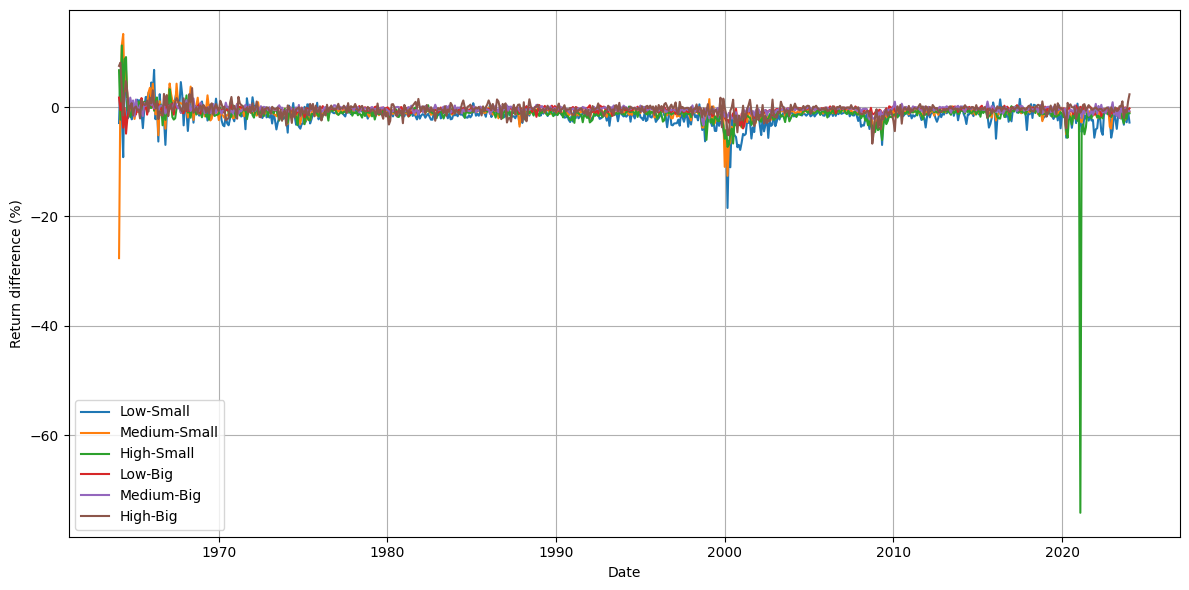

,Low-Small_diff,Medium-Small_diff,High-Small_diff,Low-Big_diff,Medium-Big_diff,High-Big_diff
median,-1.39,-0.88,-1.11,-0.37,-0.37,-0.36
mean,-1.55,-0.98,-1.31,-0.47,-0.41,-0.45


In [111]:
# Plot the return difference for each category over time
plt.figure(figsize=(12, 6))

for category in categories:
    plt.plot(df_diff['date'], df_diff[f'{category}_diff'], label=category)
    
plt.xlabel('Date')
plt.ylabel('Return difference (%)')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.savefig('Plots/return_diff.pdf')
plt.show()

# Print median and average return differences for each category with 2 decimal points
diff_stats = df_diff.drop(columns='date').agg(['median', 'mean'])
diff_stats.round(2)

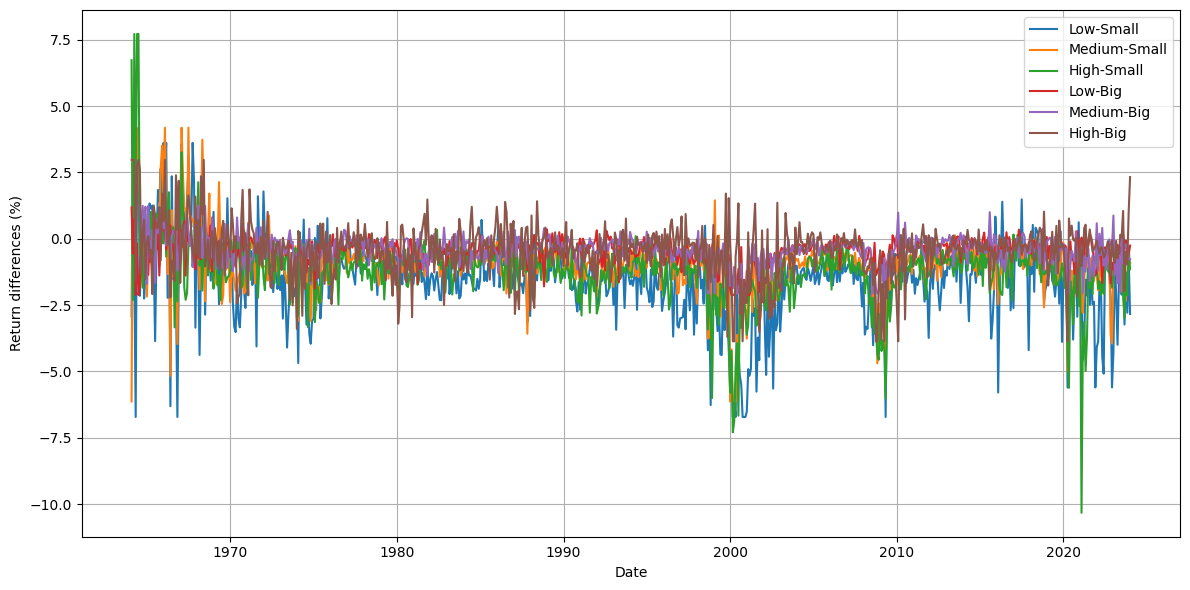

In [112]:
# Plot the return difference for each category over time when removing outliers from the data
plt.figure(figsize=(12, 6))

# Remove outliers (values more than 3 standard deviations away from the mean)
for category in categories:
    mean = df_diff[f'{category}_diff'].mean()
    std = df_diff[f'{category}_diff'].std()
    df_diff[f'{category}_diff'] = df_diff[f'{category}_diff'].clip(mean - 3 * std, mean + 3 * std)
    plt.plot(df_diff['date'], df_diff[f'{category}_diff'], label=category)

plt.xlabel('Date')
plt.ylabel('Return differences (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('Plots/return_diff_trimmed.pdf', format='pdf')
plt.show()

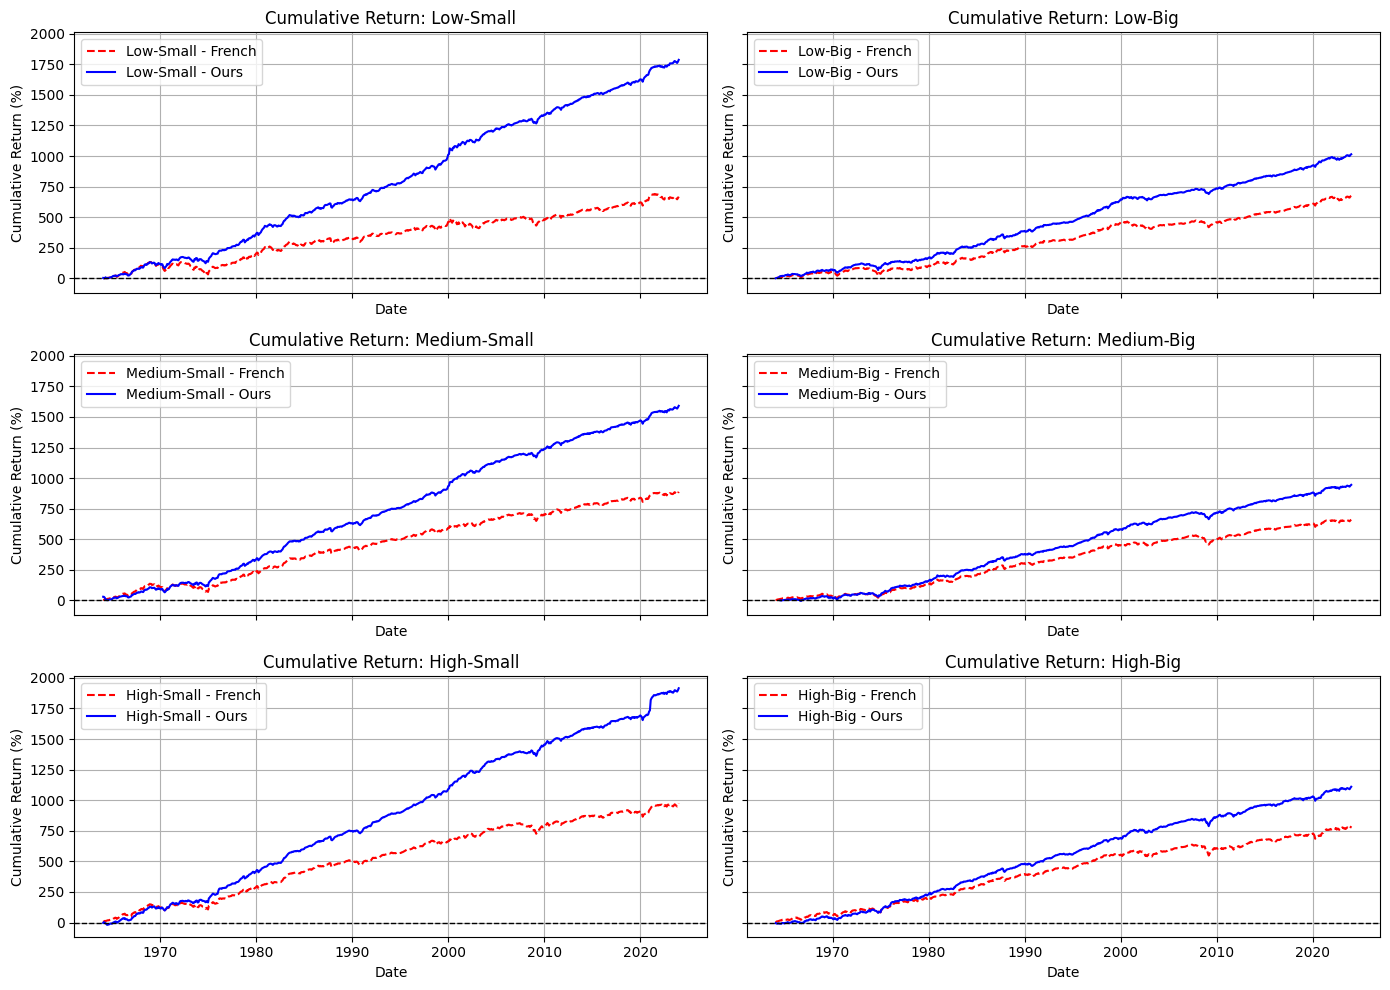

In [114]:
categories = [col for col in df_other_data.columns if col != 'date']

# Create a figure with subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=True, sharey=True)

# Define the exact mapping of categories to (row, col)
subplot_positions = {
    'Low-Small': (0, 0), 'Low-Big': (0, 1),
    'Medium-Small': (1, 0), 'Medium-Big': (1, 1),
    'High-Small': (2, 0), 'High-Big': (2, 1)
}

# Calculating the cumulative return for each column
for category in categories:
    df_merged[f'{category}_other_cum'] = df_merged[f'{category}_other'].cumsum()
    df_merged[f'{category}_vw_cum'] = df_merged[f'{category}_vw'].cumsum()

# Loop through each category and plot in its specified subplot
for category in categories:
    row, col = subplot_positions[category]  # Get the correct (row, col)
    ax = axes[row, col]  # Select the correct subplot

    # Plot cumulative returns
    ax.plot(df_merged['date'], df_merged[f'{category}_other_cum'], label=f"{category} - French", linestyle="--", color="red")
    ax.plot(df_merged['date'], df_merged[f'{category}_vw_cum'], label=f"{category} - Ours", color="blue")

    # Reference line at 0
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    # Customize subplot
    ax.set_title(f"Cumulative Return: {category}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Return (%)")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.savefig("Plots/cumulative_returns.pdf", format='pdf')
plt.show()

## Exercises

### (ii) Mean-variance calculations

##### Prepare data

In [115]:
# Read other_data.xlsx file sheet "RF"
df_market_rf_data = pd.read_excel('Data/other_data.xlsx', sheet_name='RF')
print('Shape of market_rf dataset:', df_market_rf_data.shape)
df_market_rf_data.head()

Shape of market_rf dataset: (726, 5)


,year,month,Mkt-RF,RF,RM
0,1963,7,-0.39,0.27,-0.12
1,1963,8,5.07,0.25,5.32
2,1963,9,-1.57,0.27,-1.30
3,1963,10,2.53,0.29,2.82
4,1963,11,-0.85,0.27,-0.58


In [116]:
# Only transform if 'date' column doesn't exist or isn't datetime64[ns]
if 'date' not in df_market_rf_data.columns or not pd.api.types.is_datetime64_any_dtype(df_market_rf_data['date']):
    # Combine 'year' and 'month' into a YYYYMM integer, then convert to datetime64[ns] for the end of the month
    df_market_rf_data['date'] = (df_market_rf_data['year'].astype(str) + 
                                 df_market_rf_data['month'].astype(str).str.zfill(2)).astype(int).astype(str)
    df_market_rf_data['date'] = pd.to_datetime(df_market_rf_data['date'], format='%Y%m') + pd.offsets.MonthEnd(0)
    
    # Drop the original 'year' and 'month' columns
    df_market_rf_data = df_market_rf_data.drop(columns=['year', 'month'])

# Reorder columns to place 'date' first
df_market_rf_data = df_market_rf_data[['date', 'Mkt-RF', 'RF', 'RM']]

df_market_rf_data.head()

,date,Mkt-RF,RF,RM
0,1963-07-31,-0.39,0.27,-0.12
1,1963-08-31,5.07,0.25,5.32
2,1963-09-30,-1.57,0.27,-1.30
3,1963-10-31,2.53,0.29,2.82
4,1963-11-30,-0.85,0.27,-0.58


In [117]:
# Print shape and head of df_market_rf_data
print("Shape:", df_market_rf_data.shape)
df_market_rf_data.head()

Shape: (726, 4)


,date,Mkt-RF,RF,RM
0,1963-07-31,-0.39,0.27,-0.12
1,1963-08-31,5.07,0.25,5.32
2,1963-09-30,-1.57,0.27,-1.30
3,1963-10-31,2.53,0.29,2.82
4,1963-11-30,-0.85,0.27,-0.58


In [118]:
# Print shape and head of df_vw_results
print("Shape:", df_vw_results.shape)
df_vw_results.head()

Shape: (720, 7)


,date,High-Big,High-Small,Low-Big,Low-Small,Medium-Big,Medium-Small
6,1964-01-31,-4.9844,-2.7692,0.971273,3.7736,NaN,30.4348
7,1964-02-29,-3.6066,6.4516,1.987859,-3.6364,NaN,-0.6667
8,1964-03-31,0.0000,-6.0606,0.188325,1.8868,NaN,-7.3826
9,1964-04-30,0.3448,-3.2258,4.192724,7.4074,NaN,-13.7681
10,1964-05-31,1.3746,-6.6667,1.687294,-6.8966,NaN,-1.6807


In [119]:
# Read vw_market_ret.xlsx file
df_vw_market_ret = pd.read_excel('Data/vw_market_ret.xlsx')
print('Shape of vw_market_ret dataset before dropping dates:', df_vw_market_ret.shape)

# Drop rows before 1964-01-01
df_vw_market_ret = df_vw_market_ret[df_vw_market_ret['date'] >= '1964-01-01']
print('Shape of vw_market_ret dataset after dropping dates:', df_vw_market_ret.shape)

# Multiply the columns with 100 except for the first date column
df_vw_market_ret.iloc[:, 1:] *= 100

# Rename column to 'Market'
df_vw_market_ret.rename(columns={'vw_ret': 'Market'}, inplace=True)

df_vw_market_ret.head()

Shape of vw_market_ret dataset before dropping dates: (733, 2)
Shape of vw_market_ret dataset after dropping dates: (720, 2)


,date,Market
13,1964-01-31,3.022929
14,1964-02-29,1.745027
15,1964-03-31,1.528472
16,1964-04-30,1.222248
17,1964-05-31,1.724147


In [120]:
# Merge value-weighted portfolio returns with value-weighted market returns
df_merged = pd.merge(df_vw_results, df_vw_market_ret, on='date', how='inner')

# Merge DataFrames on 'date' with an inner join (only keep matching dates)
df_merged = pd.merge(df_merged, df_market_rf_data, on='date', how='inner')

# Calculate excess returns for each portfolio (return - RF)
portfolios = ['High-Big', 'High-Small', 'Low-Big', 'Low-Small', 'Medium-Big', 'Medium-Small', 'Market']
for portfolio in portfolios:
    df_merged[f'{portfolio}'] = df_merged[portfolio] - df_merged['RF']

# Select only the 'date' and excess return columns (market and portfolios)
df_excess_returns = df_merged[['date'] + [f'{portfolio}' for portfolio in portfolios]]

print("\nShape of excess returns:", df_excess_returns.shape)
df_excess_returns.head()


Shape of excess returns: (720, 8)


,date,High-Big,High-Small,Low-Big,Low-Small,Medium-Big,Medium-Small,Market
0,1964-01-31,-5.2844,-3.0692,0.671273,3.4736,NaN,30.1348,2.722929
1,1964-02-29,-3.8666,6.1916,1.727859,-3.8964,NaN,-0.9267,1.485027
2,1964-03-31,-0.3100,-6.3706,-0.121675,1.5768,NaN,-7.6926,1.218472
3,1964-04-30,0.0548,-3.5158,3.902724,7.1174,NaN,-14.0581,0.932248
4,1964-05-31,1.1146,-6.9267,1.427294,-7.1566,NaN,-1.9407,1.464147


In [121]:
# Print mean and standard deviation of excess returns for all portfolio (including market portfolio)
excess_returns_stats = df_excess_returns.drop(columns='date').agg(['mean','std'])
excess_returns_stats = excess_returns_stats.round(2)
excess_returns_stats

,High-Big,High-Small,Low-Big,Low-Small,Medium-Big,Medium-Small,Market
mean,1.18,2.30,1.05,2.12,0.96,1.85,1.15
std,5.12,6.73,4.62,6.66,4.36,5.65,4.45


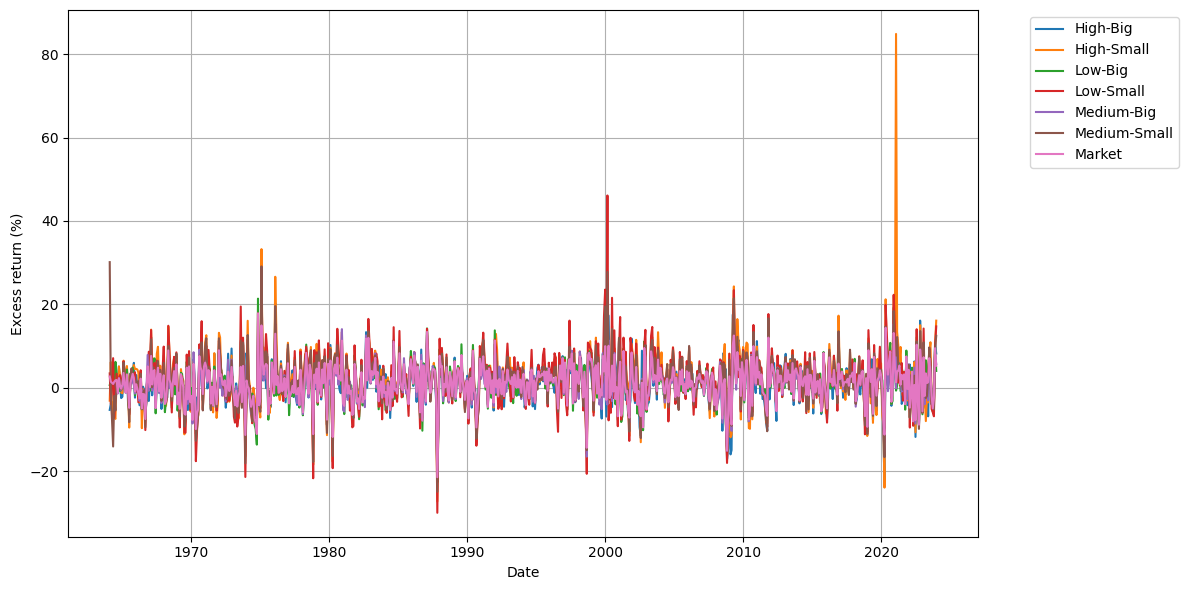

In [122]:
# Plot the excess returns for each portfolio over time
plt.figure(figsize=(12, 6))

for portfolio in portfolios:
    plt.plot(df_excess_returns['date'], df_excess_returns[portfolio], label=portfolio)

plt.xlabel('Date')
plt.ylabel('Excess return (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('Plots/vw_returns_six_portfolios_and_market.pdf')
plt.show()

##### Estimate sample returns

In [123]:
portfolios = ['High-Big', 'Low-Big', 'Medium-Big', 'High-Small', 'Low-Small', 'Medium-Small']

# Estimate the vector of sample mean excess returns
mean_excess_returns = df_excess_returns[portfolios].mean()
print("Vector of Sample Mean Excess Returns:")
mean_excess_returns.round(2)

Vector of Sample Mean Excess Returns:


High-Big        1.18
Low-Big         1.05
Medium-Big      0.96
High-Small      2.30
Low-Small       2.12
Medium-Small    1.85
dtype: float64

##### Estimate covariance matrix

In [124]:
# Estimate the covariance matrix of excess returns
covariance_matrix = df_excess_returns[portfolios].cov()
covariance_matrix = covariance_matrix.round(2)
print("\nCovariance Matrix of Excess Returns:")
covariance_matrix


Covariance Matrix of Excess Returns:


,High-Big,Low-Big,Medium-Big,High-Small,Low-Small,Medium-Small
High-Big,26.21,17.91,20.09,26.00,24.26,22.91
Low-Big,17.91,21.35,17.41,19.70,24.80,19.99
Medium-Big,20.09,17.41,19.00,21.03,21.92,19.88
High-Small,26.00,19.70,21.03,45.33,35.51,32.16
Low-Small,24.26,24.80,21.92,35.51,44.41,34.52
Medium-Small,22.91,19.99,19.88,32.16,34.52,31.96


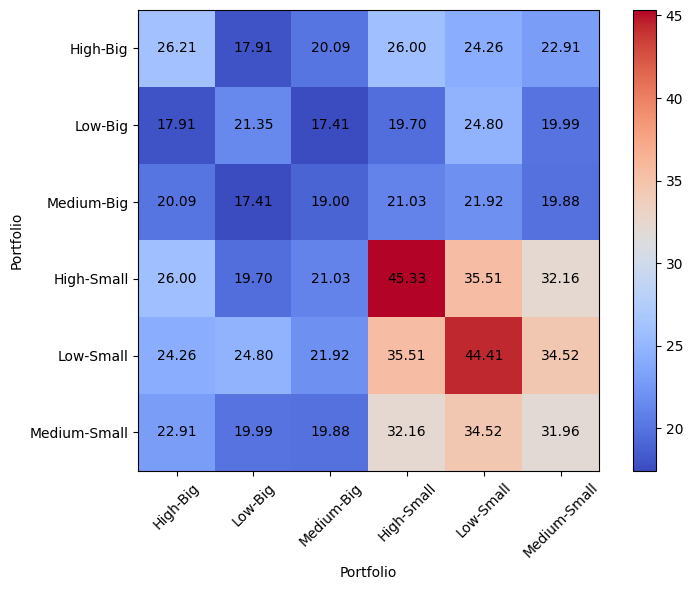

In [125]:
# Plot the covariance matrix as a heatmap with the values
plt.figure(figsize=(8, 6))
plt.imshow(covariance_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

# Add labels to the cells
for i in range(len(portfolios)):
    for j in range(len(portfolios)):
        plt.text(j, i, f'{covariance_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.xticks(range(len(portfolios)), portfolios, rotation=45)
plt.yticks(range(len(portfolios)), portfolios)

plt.xlabel('Portfolio')
plt.ylabel('Portfolio')
plt.tight_layout()
plt.savefig('Plots/covariance_matrix.pdf')
plt.show()

##### Compute two ex-post mean-variance efficient sets

In [126]:
# Drop the date column if it exists
if 'date' in df_vw_results.columns:
    df_vw_results = df_vw_results.drop(columns=['date'])

# Vector of ones
ones = np.ones(len(df_vw_results.columns))

# Covariance matrix of df_vw_results
cov_matrix = df_vw_results.cov()

# Inverse of the covariance matrix
inv_cov = np.linalg.inv(cov_matrix)

# Mean return of each portfolio
mean_return = df_vw_results.mean()

A = mean_return.T @ inv_cov @ ones
B = mean_return.T @ inv_cov @ mean_return
C = ones.T @ inv_cov @ ones
D = B * C - A ** 2

# MVF w/o riskfree 
def sigma_wo_riskfree(mu):
    return np.sqrt(1/C + C/D * (mu - A/C)**2)

# With a riskfree asset
r_0 = df_market_rf_data['RF'].mean()
H = (mean_return - r_0 * ones).T @ inv_cov @ (mean_return - r_0 * ones)

# MVF w/ riskfree asset
def sigma_w_riskfree(mu):
    return np.sqrt(((mu - r_0)**2) / H)

# MVF of w/o riskfree
mu_values = np.linspace(-5, 15, 200)
sigma_values = sigma_wo_riskfree(mu_values)
sigma_values_tangent = np.linspace(0, max(sigma_values), 200)

# MVF with riskfree asset
mu_values_w_riskfree = np.linspace(-5, 15, 200)

# Compute sigma for different values of mu with a riskfree asset
sigma_values_w_riskfree = sigma_w_riskfree(mu_values_w_riskfree)

# Tangency portfolio
mu_hat = (B - A * r_0) / (A - C * r_0)
sigma_hat = np.sqrt(H / (A - C * r_0)**2)

# Calculate mean and standard deviation of the four portfolios
mean_std = df_vw_results[['Low-Big', 'Medium-Big', 'High-Big', 'Low-Small', 'Medium-Small', 'High-Small']].agg(['mean', 'std'])
mean_std = mean_std.round(2)
mean_std

,Low-Big,Medium-Big,High-Big,Low-Small,Medium-Small,High-Small
mean,1.41,1.32,1.54,2.48,2.21,2.66
std,4.61,4.35,5.11,6.65,5.64,6.71


In [127]:
# Calculate mean and standard deviation of 'Market' in df_vw_market_ret
mean_std_market = df_vw_market_ret['Market'].agg(['mean', 'std'])
mean_std_market = mean_std_market.round(2)
mean_std_market

mean    1.51
std     4.43
Name: Market, dtype: float64

In [128]:
# Compute Sharpe ratio of tangent portfolio and market portfolio
sharpe_tangent = (mu_hat - r_0) / sigma_hat
sharpe_market = (mean_std_market['mean'] - r_0) / mean_std_market['std']

# Print Sharpe ratios
print(f"Sharpe ratio of tangency portfolio: {sharpe_tangent:.4f}")
print(f"Sharpe ratio of market portfolio: {sharpe_market:.4f}")

Sharpe ratio of tangency portfolio: 0.3633
Sharpe ratio of market portfolio: 0.2590


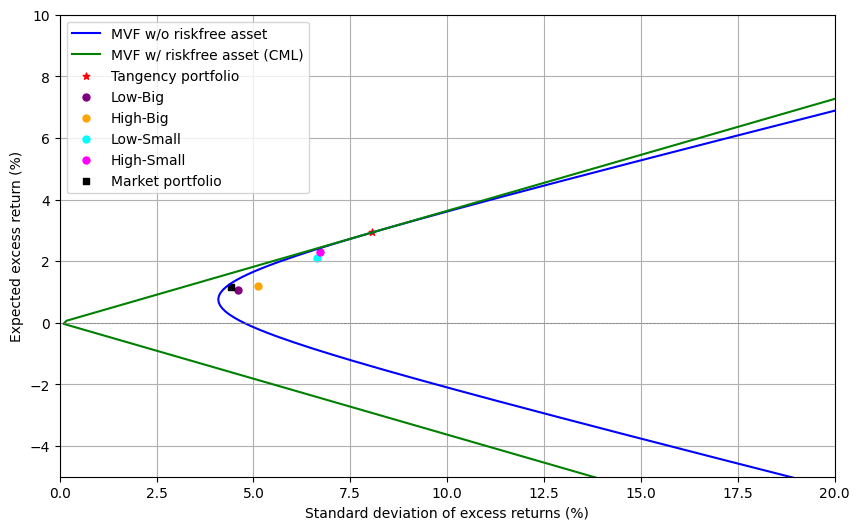

In [129]:
# Adjust to excess returns
mu_values_excess = mu_values - r_0
mu_values_w_riskfree_excess = mu_values_w_riskfree - r_0
mu_hat_excess = mu_hat - r_0

mean_std_excess = mean_std.copy()
mean_std_excess.loc['mean'] = mean_std.loc['mean'] - r_0

mean_std_market_excess = mean_std_market.copy()
mean_std_market_excess['mean'] = mean_std_market['mean'] - r_0

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot MVF without riskfree asset
plt.plot(sigma_values, mu_values_excess, label='MVF w/o riskfree asset', color='blue')

# Plot MVF with riskfree asset (CML)
plt.plot(sigma_values_w_riskfree, mu_values_w_riskfree_excess, label='MVF w/ riskfree asset (CML)', color='green')

# Define point size
point_size = 25

# Plot tangency portfolio
plt.scatter(sigma_hat, mu_hat_excess, color='red', marker='*', s=point_size, label='Tangency portfolio')

# Plot Fama-French portfolios
plt.scatter(mean_std.loc['std', 'Low-Big'], mean_std_excess.loc['mean', 'Low-Big'], 
            color='purple', marker='o', s=point_size, label='Low-Big')
plt.scatter(mean_std.loc['std', 'High-Big'], mean_std_excess.loc['mean', 'High-Big'], 
            color='orange', marker='o', s=point_size, label='High-Big')
plt.scatter(mean_std.loc['std', 'Low-Small'], mean_std_excess.loc['mean', 'Low-Small'], 
            color='cyan', marker='o', s=point_size, label='Low-Small')
plt.scatter(mean_std.loc['std', 'High-Small'], mean_std_excess.loc['mean', 'High-Small'], 
            color='magenta', marker='o', s=point_size, label='High-Small')

# Plot market portfolio
plt.scatter(mean_std_market['std'], mean_std_market_excess['mean'], 
            color='black', marker='s', s=point_size, label='Market portfolio')

# Customize the plot
plt.xlabel('Standard deviation of excess returns (%)')
plt.ylabel('Expected excess return (%)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.xlim(0, 20)
plt.ylim(-5, 10)
plt.savefig('Plots/ex_post_MVF.pdf')
plt.show()

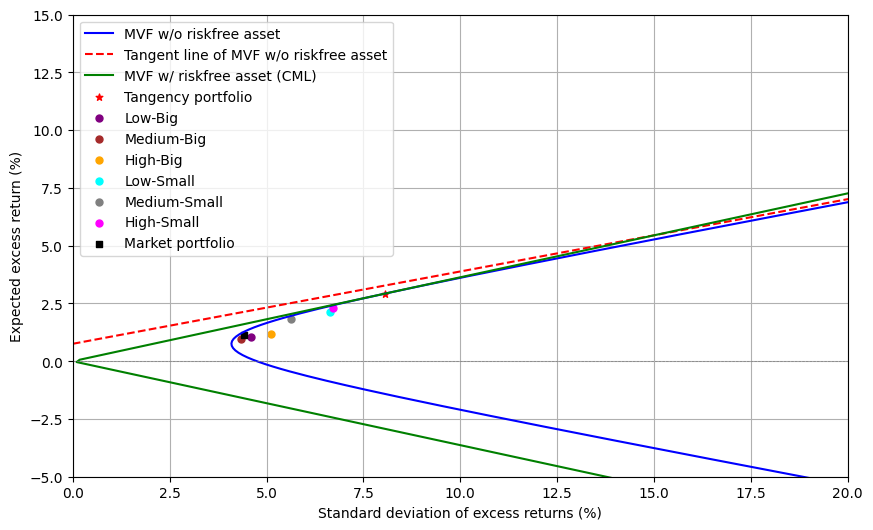

In [130]:
# Tangent line of MVF without riskless
def tangent_wo_riskless(sigma):
    return A/C + np.sqrt(D/C) * sigma

sigma_values_tangent = np.linspace(0, max(sigma_values), 200)

# Compute mu values for the tangent line of the MVF without riskless
sigma_values_tangent = np.linspace(0, max(sigma_values), 200)
mu_values_tangent = tangent_wo_riskless(sigma_values_tangent)

excess_mu_values_tangent = mu_values_tangent - r_0

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot MVF without riskfree asset
plt.plot(sigma_values, mu_values_excess, label='MVF w/o riskfree asset', color='blue')

# Plot tangent tine (without risk-free asset)
plt.plot(sigma_values_tangent, excess_mu_values_tangent, 
         label='Tangent line of MVF w/o riskfree asset', linestyle="--", color="red")

# Plot MVF with riskfree asset (CML)
plt.plot(sigma_values_w_riskfree, mu_values_w_riskfree_excess, label='MVF w/ riskfree asset (CML)', color='green')

# Define point size
point_size = 25

# Plot tangency portfolio
plt.scatter(sigma_hat, mu_hat_excess, color='red', marker='*', s=point_size, label='Tangency portfolio')

# Plot all 6 Fama-French portfolios
plt.scatter(mean_std.loc['std', 'Low-Big'], mean_std_excess.loc['mean', 'Low-Big'], 
            color='purple', marker='o', s=point_size, label='Low-Big')
plt.scatter(mean_std.loc['std', 'Medium-Big'], mean_std_excess.loc['mean', 'Medium-Big'], 
            color='brown', marker='o', s=point_size, label='Medium-Big')
plt.scatter(mean_std.loc['std', 'High-Big'], mean_std_excess.loc['mean', 'High-Big'], 
            color='orange', marker='o', s=point_size, label='High-Big')
plt.scatter(mean_std.loc['std', 'Low-Small'], mean_std_excess.loc['mean', 'Low-Small'], 
            color='cyan', marker='o', s=point_size, label='Low-Small')
plt.scatter(mean_std.loc['std', 'Medium-Small'], mean_std_excess.loc['mean', 'Medium-Small'], 
            color='grey', marker='o', s=point_size, label='Medium-Small')
plt.scatter(mean_std.loc['std', 'High-Small'], mean_std_excess.loc['mean', 'High-Small'], 
            color='magenta', marker='o', s=point_size, label='High-Small')

# Plot market portfolio
plt.scatter(mean_std_market['std'], mean_std_market_excess['mean'], 
            color='black', marker='s', s=point_size, label='Market portfolio')

# Customize the plot
plt.xlabel('Standard deviation of excess returns (%)')
plt.ylabel('Expected excess return (%)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.xlim(0, 20)
plt.ylim(-5, 15)
plt.savefig('Plots/ex_post_MVF_v2.pdf')
plt.show()

### (iii) Security market line (SML)

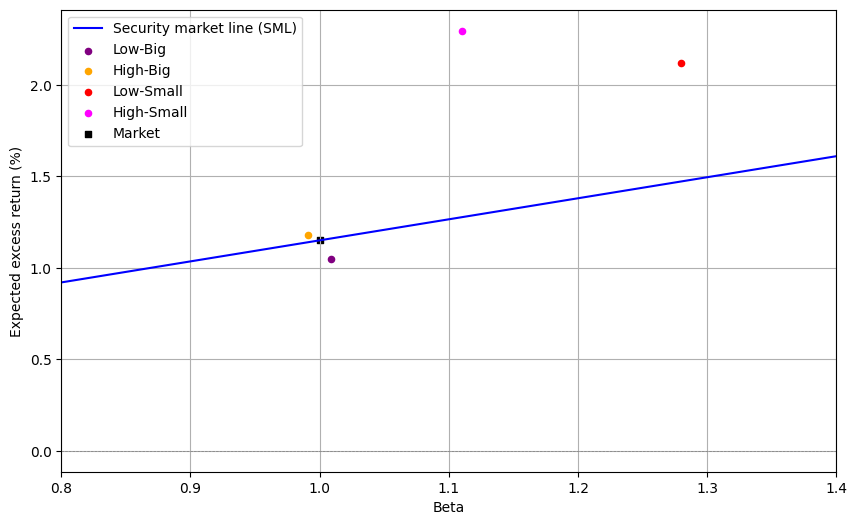

In [131]:
# Drop the 'date' column if it exists
if 'date' in df_excess_returns.columns:
    df_excess_returns = df_excess_returns.drop(columns=['date'])

# List of portfolio names (excluding 'Market')
portfolios = [col for col in df_excess_returns.columns if col != 'Market']

# Market excess returns
market_excess = df_excess_returns['Market']

# Dictionaries to store betas and alphas
betas = {}
alphas = {}

# Regress each portfolio's excess returns against market excess returns
for portfolio in portfolios:
    # Check for NaN values in the portfolio or market data
    portfolio_data = df_excess_returns[portfolio]
    if portfolio_data.isnull().all() or market_excess.isnull().all():
        print(f"Skipping {portfolio} due to all NaN values")
        continue
    
    # Drop NaN pairs to avoid regression errors
    valid_data = pd.concat([portfolio_data, market_excess], axis=1).dropna()
    if len(valid_data) < 2:  # Need at least 2 points for regression
        print(f"Skipping {portfolio} due to insufficient valid data")
        continue
    
    X = sm.add_constant(valid_data['Market'])  # Add constant for intercept (alpha)
    model = sm.OLS(valid_data[portfolio], X).fit()
    alphas[portfolio] = model.params['const']  # Alpha = intercept
    betas[portfolio] = model.params['Market']  # Beta = slope

# Market portfolio: beta = 1, alpha = 0 by definition
betas['Market'] = 1.0
alphas['Market'] = 0.0

# Calculate expected excess returns (mean of each column, ignoring NaN)
expected_excess_returns = df_excess_returns.mean()

# Market expected excess return
market_excess_return = expected_excess_returns['Market']

# Define SML: expected excess return = beta * market excess return
beta_range = np.linspace(0, max(betas.values()) * 1.2, 100)  # Extend slightly beyond max beta
sml_returns = beta_range * market_excess_return

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the SML
plt.plot(beta_range, sml_returns, label='Security market line (SML)', color='blue')

# Portfolios to plot (excluding 'Medium-Big' and 'Medium-Small')
plot_portfolios = ['Low-Big', 'High-Big', 'Low-Small', 'High-Small', 'Market']

# Scatter the selected portfolios
point_size = 20
colors = {
    'Low-Big': 'purple',
    'High-Big': 'orange',
    'Low-Small': 'red',
    'High-Small': 'magenta',
    'Market': 'black'
}

for portfolio in plot_portfolios:
    if portfolio in betas and not pd.isna(expected_excess_returns[portfolio]):
        color = colors[portfolio]
        marker = 's' if portfolio == 'Market' else 'o'
        plt.scatter(betas[portfolio], expected_excess_returns[portfolio], 
                    color=color, marker=marker, s=point_size, label=portfolio)
    else:
        print(f"Skipping {portfolio} in plot due to missing beta or expected return")

# Customize the plot
plt.xlabel('Beta')
plt.ylabel('Expected excess return (%)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.xlim(0.8, 1.4)
plt.savefig('Plots/ex_post_SML.pdf')
plt.show()

### (iv) Regressions

In [132]:
# Save df_excess_returns to an Excel file
df_excess_returns.to_excel('Data/excess_returns.xlsx', index=False)

In [133]:
# Load df_excess_returns from the Excel file
df_excess_returns = pd.read_excel('Data/excess_returns.xlsx')

In [134]:
# Drop the 'date' column if it exists
if 'date' in df_excess_returns.columns:
    df_excess_returns = df_excess_returns.drop(columns=['date'])

# Define the four portfolios to analyze
portfolios = ['Low-Big', 'High-Big', 'Low-Small', 'High-Small']

# Market excess returns (independent variable: RM,t - Rf,t)
market_excess = df_excess_returns['Market']

# Dictionaries to store betas, alphas, and regression summaries
betas = {}
alphas = {}
regression_summaries = {}

# Run OLS regression for each portfolio
for portfolio in portfolios:
    # Check for NaN values
    portfolio_data = df_excess_returns[portfolio]
    if portfolio_data.isnull().all() or market_excess.isnull().all():
        print(f"Skipping {portfolio} due to all NaN values")
        continue

    # Drop NaN pairs
    valid_data = pd.concat([portfolio_data, market_excess], axis=1).dropna()
    if len(valid_data) < 2:
        print(f"Skipping {portfolio} due to insufficient valid data")
        continue

    # OLS regression
    X = sm.add_constant(valid_data['Market'])  # Add constant for alpha
    model = sm.OLS(valid_data[portfolio], X).fit()
    alphas[portfolio] = model.params['const']
    betas[portfolio] = model.params['Market']

# Market portfolio: beta = 1, alpha = 0 by definition
betas['Market'] = 1.0
alphas['Market'] = 0.0

print("OLS Regression Results: RP,t - Rf,t = αP + βP (RM,t - Rf,t) + εP,t")

print("\nBetas:")
for portfolio, beta in betas.items():
    print(f"{portfolio}: {beta:.4f}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: {alpha:.4f}")

# Print full regression summary for each portfolio
for portfolio in portfolios:
    if portfolio in betas:  # Only print if regression was successful
        valid_data = pd.concat([df_excess_returns[portfolio], market_excess], axis=1).dropna()
        X = sm.add_constant(valid_data['Market'])
        model = sm.OLS(valid_data[portfolio], X).fit()
        print(f"\nRegression summary for {portfolio}:")
        print(model.summary())

OLS Regression Results: RP,t - Rf,t = αP + βP (RM,t - Rf,t) + εP,t

Betas:
Low-Big: 1.0085
High-Big: 0.9908
Low-Small: 1.2797
High-Small: 1.1105
Market: 1.0000

Alphas:
Low-Big: -0.1138
High-Big: 0.0382
Low-Small: 0.6461
High-Small: 1.0188
Market: 0.0000

Regression summary for Low-Big:
                            OLS Regression Results                            
Dep. Variable:                Low-Big   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                 1.172e+04
Date:                Mon, 24 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:07:02   Log-Likelihood:                -1096.4
No. Observations:                 720   AIC:                             2197.
Df Residuals:                     718   BIC:                             2206.
Df Model:                           1                                         
C

In [137]:
model = {}
# Print full regression summary for each portfolio
for portfolio in portfolios:
    if portfolio in betas:  # Only print if regression was successful
        valid_data = pd.concat([df_excess_returns[portfolio], market_excess], axis=1).dropna()
        X = sm.add_constant(valid_data['Market'])
        model[portfolio] = sm.OLS(valid_data[portfolio], X).fit()

pystout(models=[model['Low-Big'], model['High-Big'], model['Low-Small'], model['High-Small']],
        file='Tables/reg_CAPM_table.tex',
        addnotes=['Standard errors in parantheses','*** p<0.001, ** p<0.005, * p<0.01'],
        digits=2,
        endog_names=['Low-Big','High-Big','Low-Small','High-Small'],
        varlabels={'const':r'$\alpha$',
                   'Market': r'$\beta$'},
        modstat={'nobs':'Obs','rsquared':'R\sym{2}'}
        )

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
C:\Users\65608\AppData\Local\Temp\ipykernel_12232\750179372.py:16: SyntaxWarning: invalid escape sequence '\s'
  modstat={'nobs':'Obs','rsquared':'R\sym{2}'}
